In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Leitura do conjunto de dados
data = np.loadtxt('datasetTC4.dat')
data.shape

(310, 6)

In [3]:
# Passo 1 - Normalizar os dados
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized

array([[ 0.14722652,  0.50111133, -0.66512805, -0.18460234, -1.44783071,
        -0.70794606],
       [-1.24570706, -0.74889057, -1.45276272, -1.04124965, -0.26402779,
        -0.57967342],
       [ 0.48427345,  0.46808485, -0.0993699 ,  0.27282344, -0.89729467,
        -0.79541679],
       ...,
       [ 0.05541029,  0.51512256, -0.31098936, -0.31369641,  0.58283504,
        -0.77354911],
       [-0.88599664, -0.88600047, -0.55877847, -0.47711606,  0.04734096,
        -0.69567882],
       [-1.54904929, -1.24829085, -0.82546218, -1.05841244,  0.45347411,
        -0.70661266]])

## Questão Única: Implementar os algoritmos K-médias e K-medianas usando o conjunto de dados disponibilizado no SIGAA (datasetTC4.dat).

In [4]:
N, M = data.shape

# Número de protótipos escolhido
K = 4  

# Posição inicial dos protótipos
I = np.random.choice(N, K, replace=False)
W = data[I, :]

In [5]:
def k_means(data, K, Ne=10):
    N, M = data.shape

    # Inicialização dos protótipos
    I = np.random.choice(N, K, replace=False)
    W = data[I, :]

    SSD = np.zeros(Ne)

    for r in range(Ne):
        # Busca pelo protótipo mais próximo do vetor de atributos
        Dmin = np.linalg.norm(data - W[:, np.newaxis, :], axis=-1).min(axis=0)
        Icluster = np.argmin(np.linalg.norm(data - W[:, np.newaxis, :], axis=-1), axis=0)

        SSD[r] = np.sum(Dmin ** 2)

        # Particiona dados em K subconjuntos e atualiza protótipo correspondente
        for k in range(K):
            I = np.where(Icluster == k)[0]
            Particao = data[I, :]
            W[k, :] = np.mean(Particao, axis=0)

        # Calcula SSD
        Dmin = np.linalg.norm(data - W[:, np.newaxis, :], axis=-1).min(axis=0)
        Icluster = np.argmin(np.linalg.norm(data - W[:, np.newaxis, :], axis=-1), axis=0)

    return W, SSD, Icluster

In [6]:
# Chama a função k_means
final_prototypes, ssd_values, labels = k_means(data, K)

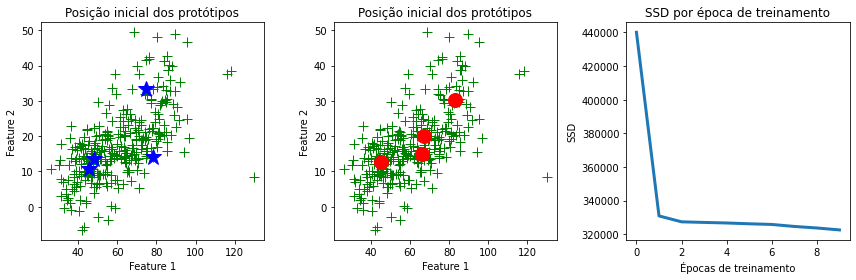

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(data[:, 0], data[:, 1], 'g+', markersize=10, linewidth=3)
axes[0].plot(W[:, 0], W[:, 1], 'b*', markersize=17, linewidth=4)
axes[0].set_title('Posição inicial dos protótipos')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].plot(data[:, 0], data[:, 1], 'g+', markersize=10, linewidth=3)
axes[1].plot(final_prototypes[:, 0], final_prototypes[:, 1], 'ro', markersize=14, linewidth=4)
axes[1].set_title('Posição inicial dos protótipos')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')


axes[2].plot(ssd_values, linewidth=3)
axes[2].set_xlabel('Épocas de treinamento')
axes[2].set_ylabel('SSD')
axes[2].set_title('SSD por época de treinamento')


plt.tight_layout()
plt.show()

### 1.1 Usando o algoritmo K-médias, estimar o número de agrupamentos através dos ı́ndices de validação:

## 1 - Dunn

In [8]:
# Função para calcular o índice de Dunn
def dunn_index(X, labels, centroids):
    X_array = X
    dist_matrix = np.linalg.norm(X_array - centroids[labels], axis=-1)

    min_diameter = np.inf
    for k in range(len(centroids)):
        cluster_points = X_array[labels == k]
        cluster_diameter = np.max(np.linalg.norm(cluster_points - centroids[k], axis=-1))
        min_diameter = min(min_diameter, cluster_diameter)

    mask = labels != labels[:, np.newaxis]
    min_intercluster_distance = np.min(dist_matrix[mask.any(axis=1)])

    if min_diameter == 0:
        return np.nan
    else:
        return min_intercluster_distance / min_diameter

## 2 - Davies-Bouldin

In [9]:
# Função para calcular o índice de Davies-Bouldin
def davies_bouldin_index(X, labels, centroids):
    X_array = X.values if isinstance(X, pd.DataFrame) else X
    num_clusters = len(centroids)
    distances_matrix = np.zeros((num_clusters, num_clusters))

    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            distances_matrix[i, j] = np.linalg.norm(centroids[i] - centroids[j])
            distances_matrix[j, i] = distances_matrix[i, j]

    max_cluster_distances = np.zeros(num_clusters)

    for k in range(num_clusters):
        cluster_points = X_array[labels == k]
        mean_distance = np.mean(np.linalg.norm(cluster_points - centroids[k], axis=-1))
        max_cluster_distances[k] = max([distances_matrix[k, j] for j in range(num_clusters) if j != k])

    return np.sum(max_cluster_distances) / num_clusters

## 3 - Calinski-Harabasz

In [10]:
# Função para calcular a métrica de Calinski-Harabasz
def calinski_harabasz_index(X, labels, centroids):
    X_array = X.values if isinstance(X, pd.DataFrame) else X
    num_samples, num_features = X_array.shape
    num_clusters = len(centroids)

    overall_mean = np.mean(X_array, axis=0)
    overall_ss = np.sum(np.sum((X_array - overall_mean) ** 2, axis=1))

    between_cluster_ss = 0
    within_cluster_ss = 0

    for k in range(num_clusters):
        cluster_points = X_array[labels == k]
        cluster_size = len(cluster_points)

        cluster_mean = np.mean(cluster_points, axis=0)
        between_cluster_ss += cluster_size * np.sum((cluster_mean - overall_mean) ** 2)

        within_cluster_ss += np.sum(np.sum((cluster_points - cluster_mean) ** 2, axis=1))

    return (between_cluster_ss / (num_clusters - 1)) / (within_cluster_ss / (num_samples - num_clusters))

Resultado do índice de Dunn:
 - Valor ótimo de K: 6
 - Índices de Dunn para diferentes valores de K: [0.08398273574588201, 0.0702585092406391, 0.11069440489236046, 0.14702390080741004, nan, 0.1378072916064448, nan, nan, nan, nan, nan, 0.2203269456650702, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

Resultado do índice de Davies-Bouldin:
 - Valor ótimo de K: 2
 - Índices de Dunn para diferentes valores de K: [68.89936399780201, 83.8863386699443, 89.35595625147845, 93.23405542902296, 406.21358362359723, 191.2442639377844, 404.05639784153436, 404.26911754284833, 413.06643354860205, 420.34977333312304, 407

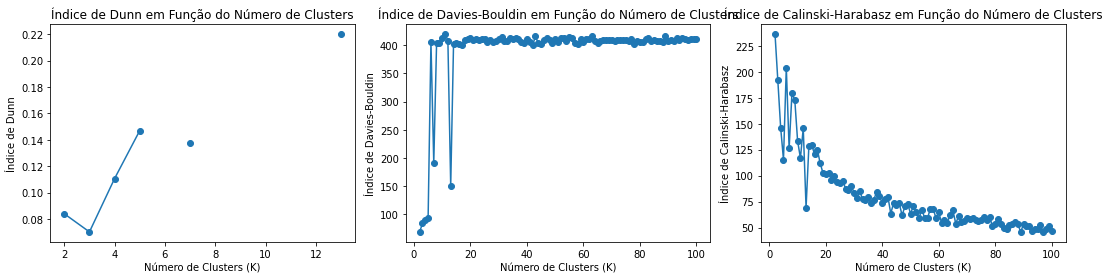

In [11]:
# Número máximo de clusters a serem testados
max_clusters = 100

# Inicializar listas para armazenar os resultados dos índices
dunn_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in range(2, max_clusters + 1):
    # Chama a função k_medians
    final_prototypes, _, labels = k_means(data, k)

    # Calcula o índice de Dunn
    dunn_score = dunn_index(data, labels, final_prototypes)
    davies_bouldin_score = davies_bouldin_index(data, labels, final_prototypes)
    calinski_harabasz_score = calinski_harabasz_index(data, labels, final_prototypes)

    # Armazena o índice de Dunn para o valor atual de K
    dunn_scores.append(dunn_score)
    davies_bouldin_scores.append(davies_bouldin_score)
    calinski_harabasz_scores.append(calinski_harabasz_score)

# Encontrar o valor ótimo de K para cada índice
optimal_k_dunn = np.argmax(dunn_scores) + 2  # Adiciona 2 porque começamos com K=2
optimal_k_davies_bouldin = np.argmin(davies_bouldin_scores) + 2
optimal_k_calinski_harabasz = np.argmax(calinski_harabasz_scores) + 2

# Imprimir os resultados
print("Resultado do índice de Dunn:")
print(" - Valor ótimo de K:", optimal_k_dunn)
print(" - Índices de Dunn para diferentes valores de K:", dunn_scores)

print("\nResultado do índice de Davies-Bouldin:")
print(" - Valor ótimo de K:", optimal_k_davies_bouldin)
print(" - Índices de Dunn para diferentes valores de K:", davies_bouldin_scores)

print("\nResultado do índice de Calinski-Harabasz:")
print(" - Valor ótimo de K:", optimal_k_davies_bouldin)
print(" - Índices de Calinski-Harabasz para diferentes valores de K:", calinski_harabasz_scores)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(range(2, max_clusters + 1), dunn_scores, marker='o')
axes[0].set_xlabel('Número de Clusters (K)')
axes[0].set_ylabel('Índice de Dunn')
axes[0].set_title('Índice de Dunn em Função do Número de Clusters')

axes[1].plot(range(2, max_clusters + 1), davies_bouldin_scores, marker='o')
axes[1].set_xlabel('Número de Clusters (K)')
axes[1].set_ylabel('Índice de Davies-Bouldin')
axes[1].set_title('Índice de Davies-Bouldin em Função do Número de Clusters')

axes[2].plot(range(2, max_clusters + 1), calinski_harabasz_scores, marker='o')
axes[2].set_xlabel('Número de Clusters (K)')
axes[2].set_ylabel('Índice de Calinski-Harabasz')
axes[2].set_title('Índice de Calinski-Harabasz em Função do Número de Clusters')

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()

## (i) Qual valor para o número de agrupamentos foi sugerido por cada técnica de validação?

In [ ]:
Dunn: K (Kopt) = 6
Davies-Bouldin: K (Kopt) = 2
Calinski-Harabasz: K (Kopt) = 2

## (ii) Se houve divergência entre os resultados sugeridos pelos ı́ndices, o que justifica tal divergência?

Os índices de avaliação de cluster podem fornecer resultados diferentes porque estão otimizando diferentes aspectos da qualidade do agrupamento.
O índice de Dunn visa medir a compactação intracluster em relação à separação intercluster.
O índice de Davies-Bouldin avalia a compactação intracluster e a separação intercluster, tentando minimizar a compactação intracluster e maximizar a separação intercluster.
O índice Calinski-Harabasz avalia a razão entre a dispersão entre clusters e a dispersão intracluster, buscando maximizar essa razão.

## 1.2 Rodar o algoritmo K-medianas usando o número de agrupamentos escolhidos no Subitem 1

In [12]:
def k_medians(data, K, Ne=10):
    N, M = data.shape

    # Inicialização dos protótipos
    I = np.random.choice(N, K, replace=False)
    W = data[I, :]

    SSD = np.zeros(Ne)

    for r in range(Ne):
        # Busca pelo protótipo mais próximo do vetor de atributos
        Dmin = np.linalg.norm(data - W[:, np.newaxis, :], axis=-1).min(axis=0)
        Icluster = np.argmin(np.linalg.norm(data - W[:, np.newaxis, :], axis=-1), axis=0)

        SSD[r] = np.sum(Dmin ** 2)

        # Particiona dados em K subconjuntos e atualiza protótipo correspondente
        for k in range(K):
            I = np.where(Icluster == k)[0]
            Particao = data[I, :]
            W[k, :] = np.median(Particao, axis=0)

        # Calcula SSD
        Dmin = np.linalg.norm(data - W[:, np.newaxis, :], axis=-1).min(axis=0)
        Icluster = np.argmin(np.linalg.norm(data - W[:, np.newaxis, :], axis=-1), axis=0)

    return W, SSD, Icluster

In [15]:
# Chama a função k_medians
final_prototypes, ssd_values, labels = k_medians(data, 2)

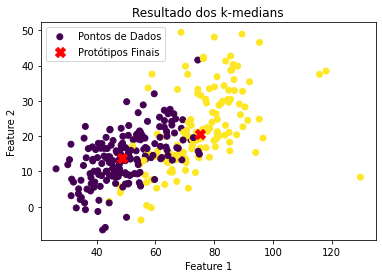

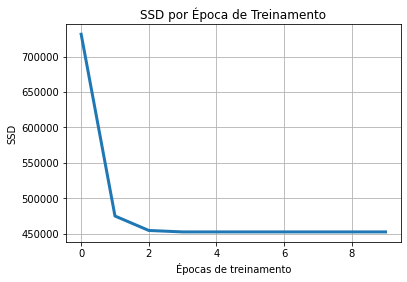

In [16]:
# Plotar os protótipos e os pontos de dados
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', label='Pontos de Dados')
plt.scatter(final_prototypes[:, 0], final_prototypes[:, 1], c='red', marker='X', label='Protótipos Finais', s=100)
plt.title('Resultado dos k-medians')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Plotar a evolução do SSD ao longo das épocas de treinamento
plt.plot(ssd_values, linewidth=3)
plt.grid()
plt.xlabel('Épocas de treinamento')
plt.ylabel('SSD')
plt.title('SSD por Época de Treinamento')
plt.show()

Resultado do índice de Dunn:
 - Valor ótimo de K: 21
 - Índices de Dunn para diferentes valores de K: [0.11092871706199936, 0.08763187921837294, 0.11377419390725611, 0.12270470284505965, 0.12776897095120582, 0.11462643913077951, 0.12777966525601928, 0.1669710261374545, 0.21377278452608214, 0.13536745935355352, 0.09043308306783894, 0.18328816483916335, 0.15686794355114336, 0.1973786034143347, 0.16849020786901692, 0.20855554134440227, 0.19114655356510005, 0.10598840282814234, 0.08029402720980056, nan, 0.11462779050876655, nan, nan, 0.09958291722602164, 0.09110719873317158, 0.09888321885899788, nan, 0.21060045915093115, nan, 0.2704096612604625, nan, nan, nan, 0.2096454297576, nan, nan, 0.10558534781396645, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.34355728861206186, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

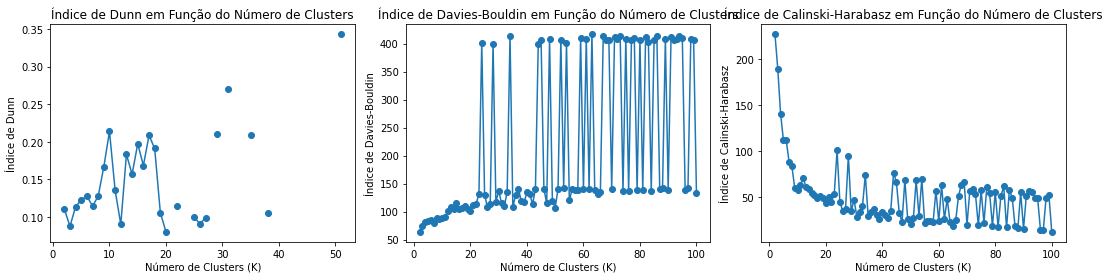

In [14]:
# Número máximo de clusters a serem testados
max_clusters = 100

# Inicializar listas para armazenar os resultados dos índices
dunn_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in range(2, max_clusters + 1):
    # Chama a função k_medians
    final_prototypes, _, labels = k_medians(data, k)

    # Calcula o índice de Dunn
    dunn_score = dunn_index(data, labels, final_prototypes)
    davies_bouldin_score = davies_bouldin_index(data, labels, final_prototypes)
    calinski_harabasz_score = calinski_harabasz_index(data, labels, final_prototypes)

    # Armazena o índice de Dunn para o valor atual de K
    dunn_scores.append(dunn_score)
    davies_bouldin_scores.append(davies_bouldin_score)
    calinski_harabasz_scores.append(calinski_harabasz_score)

# Encontrar o valor ótimo de K para cada índice
optimal_k_dunn = np.argmax(dunn_scores) + 2  # Adiciona 2 porque começamos com K=2
optimal_k_davies_bouldin = np.argmin(davies_bouldin_scores) + 2
optimal_k_calinski_harabasz = np.argmax(calinski_harabasz_scores) + 2

# Imprimir os resultados
print("Resultado do índice de Dunn:")
print(" - Valor ótimo de K:", optimal_k_dunn)
print(" - Índices de Dunn para diferentes valores de K:", dunn_scores)

print("\nResultado do índice de Davies-Bouldin:")
print(" - Valor ótimo de K:", optimal_k_davies_bouldin)
print(" - Índices de Dunn para diferentes valores de K:", davies_bouldin_scores)

print("\nResultado do índice de Calinski-Harabasz:")
print(" - Valor ótimo de K:", optimal_k_davies_bouldin)
print(" - Índices de Calinski-Harabasz para diferentes valores de K:", calinski_harabasz_scores)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(range(2, max_clusters + 1), dunn_scores, marker='o')
axes[0].set_xlabel('Número de Clusters (K)')
axes[0].set_ylabel('Índice de Dunn')
axes[0].set_title('Índice de Dunn em Função do Número de Clusters')

axes[1].plot(range(2, max_clusters + 1), davies_bouldin_scores, marker='o')
axes[1].set_xlabel('Número de Clusters (K)')
axes[1].set_ylabel('Índice de Davies-Bouldin')
axes[1].set_title('Índice de Davies-Bouldin em Função do Número de Clusters')

axes[2].plot(range(2, max_clusters + 1), calinski_harabasz_scores, marker='o')
axes[2].set_xlabel('Número de Clusters (K)')
axes[2].set_ylabel('Índice de Calinski-Harabasz')
axes[2].set_title('Índice de Calinski-Harabasz em Função do Número de Clusters')

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()